In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pinocchio as pin
from src.embedding import Embedding
from src.forward_kinematics import ForwardKinematic
from src.dynamical_system import DynamicalSystem
from utils.franka_parameters import joint_limits
from utils.visualization import visualize_robot, plot_3d_ellipsoid_from_covariance, plot_coupled_embeddings

In [2]:
fk = ForwardKinematic(urdf_file='franka_description/urdf/panda_no_gripper.urdf', components_per_link=3)
config_dim = fk.model.nq

K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)

lower_bound = np.array([limit['lower'] for limit in joint_limits])
upper_bound = np.array([limit['upper'] for limit in joint_limits])
# config_attractor = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
config_attractor = np.array([-1.98940735, -0.34923044, -2.14521628, -2.74515598,  2.89106801, 0.80532853,  0.07493805])
print(f'attractor : {config_attractor}')

x = np.array([[-0.2], [-0.1], [0.6]])[np.newaxis, :]

e = Embedding(dimension=config_dim, x=x.repeat(1, 0), fk=fk, limits=joint_limits)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

attractor : [-1.98940735 -0.34923044 -2.14521628 -2.74515598  2.89106801  0.80532853
  0.07493805]


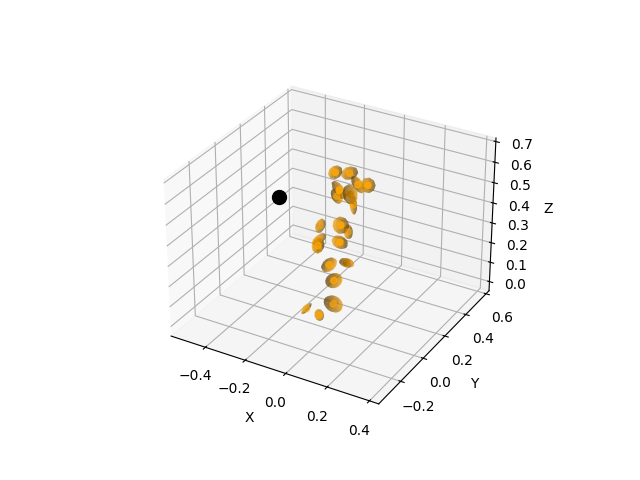

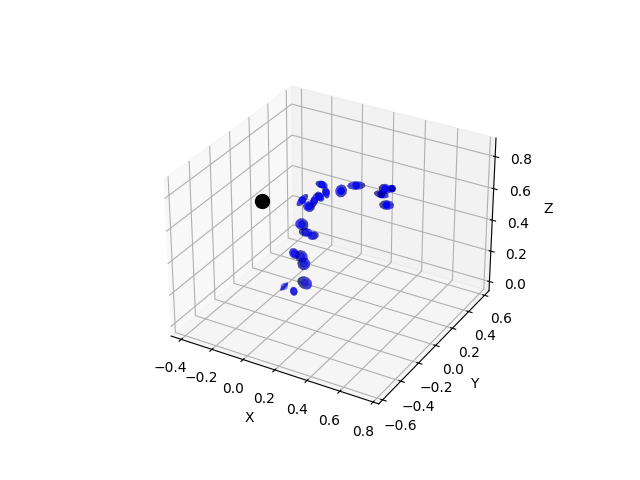

In [3]:
%matplotlib widget

config_start = np.array([0., 0., 0., -1.5, 0., 1.5, 0.])
initial_speed = np.array([0, 0, 0, 0, 0, 0, 0.]) 

# config_attractor = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
speed = np.zeros_like(config_attractor)
fk(config_start, speed, derivation_order=0)
visualize_robot(fk=fk, obstacle=x, color='blue')
fk(config_attractor, speed, derivation_order=0)
visualize_robot(fk=fk, obstacle=x, color='orange')
plt.show()

In [4]:
# config_start = pin.neutral(fk.model)
# config_start = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
# initial_speed = np.zeros_like(config_start)
q = config_start
dq = initial_speed
positions = []
velocities = []
frequencies = []
for i in range(0,1000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    velocities.append(dq)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')
ps= np.stack(positions)

average execution frequency : 67.1263 Hz


# Visualization

In [5]:
def generate_grid_coordinates(joint_limits, resolution: int=5):
    qs = tuple(np.linspace(-np.pi, np.pi, resolution) for limit in joint_limits)
    # qs = tuple(np.linspace(limit['lower'], limit['upper'], resolution) for limit in joint_limits)
    grids = np.meshgrid(*qs)
    return np.column_stack(tuple(g.ravel() for g in grids))

grid = generate_grid_coordinates(joint_limits=joint_limits, resolution=5)
print(grid.shape)

(78125, 7)


In [6]:
a = np.zeros((grid.shape[0], grid.shape[1]+1))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q).sum()
    a[i] = np.array([*q, p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 3863.003376243991


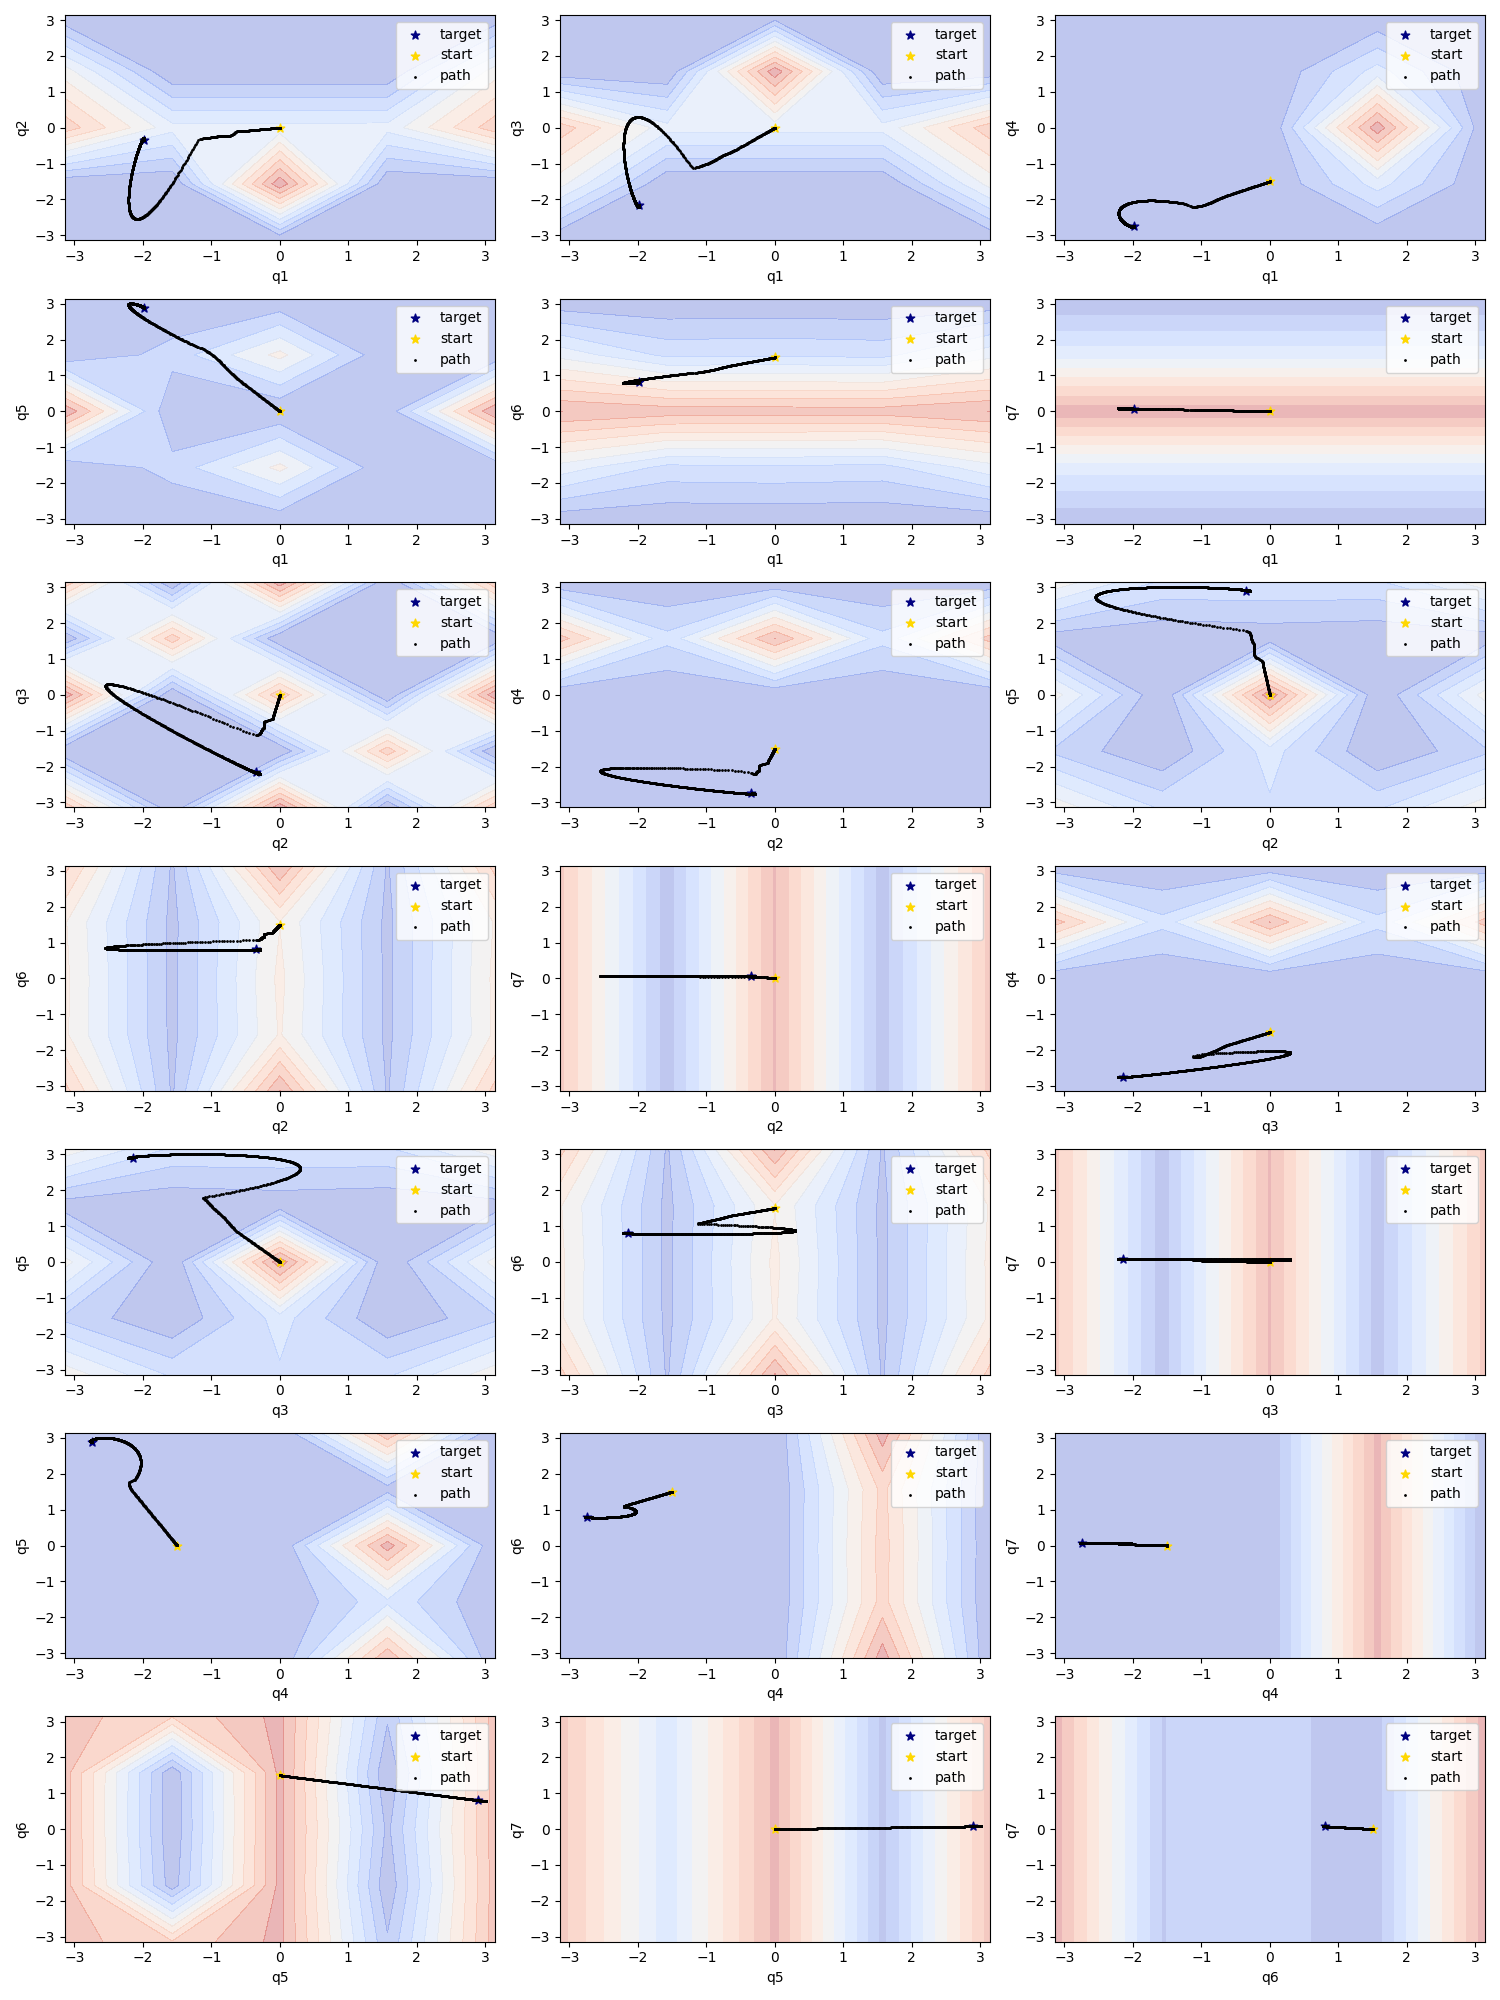

In [7]:
plot_coupled_embeddings(grid, config_attractor, embedding=a, streamlines=ps, start=config_start)
plt.show()

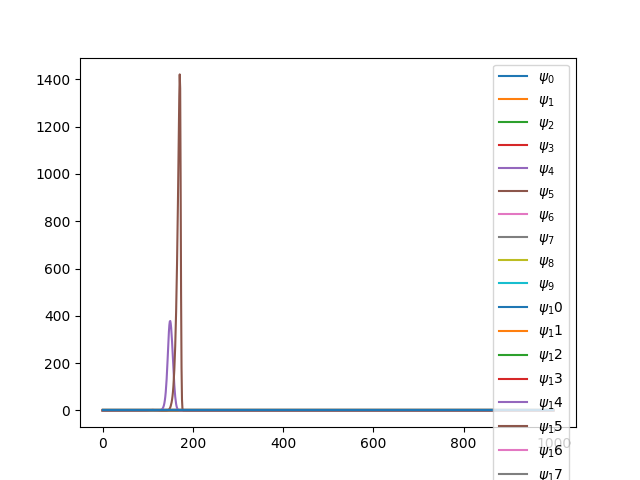

In [8]:
psi = np.stack(ds.embedding_logger)
plt.figure()
for i in range(psi.shape[2]):
    plt.plot(range(psi.shape[0]), psi[:, :, i], label=rf'$\psi_{i}$')
plt.legend()
plt.show()

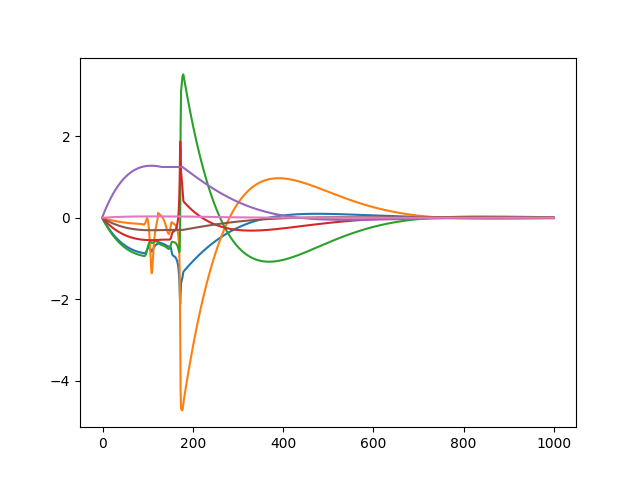

In [9]:
vel = np.stack(velocities)
plt.figure()
plt.plot(range(vel.shape[0]), vel)
plt.show()

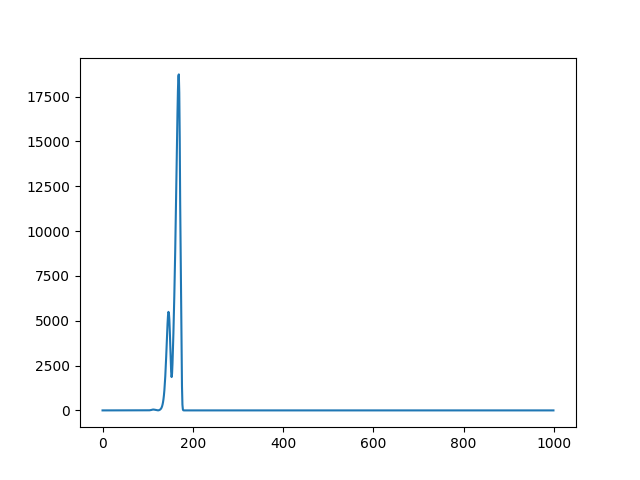

In [10]:
grad = np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(grad.shape[0]), np.linalg.norm(grad, axis=2))
plt.show()

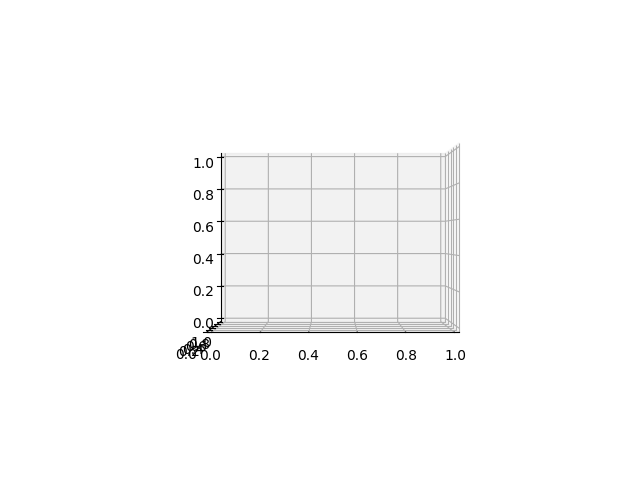

In [12]:
from matplotlib import animation

def animate_robot(i, configurations, fk: ForwardKinematic, obstacle, ax):
    ax.set_aspect('equal')
    ax.set_xlim(-0.1, 2)
    ax.clear()
    ax.scatter(obstacle[:, 0], obstacle[:, 1], obstacle[:, 2], c='black', s=100)
    q = configurations[i]
    pin.forwardKinematics(fk.model, fk.data, q)
    pin.updateFramePlacements(fk.model, fk.data)
    _ = fk(q=q, dq=np.zeros_like(q), derivation_order=0)
    ax.scatter(*(fk.mus[:, i] for i in range(3)))
    for i in range(fk.sigmas.shape[0]):
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_zlim(-0.1, 1)
        ax.set_aspect('equal')
        plot_3d_ellipsoid_from_covariance(fk.sigmas[i], center=fk.mus[i], ax=ax)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(azim=-90, elev=0)
dt = 0.004
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, ps.shape[0], step, dtype=np.intc),fargs=(ps, fk, x, ax), interval=step*dt*1000, repeat=False)
# ani.save('vid.mp4')